# CIFAR-10 Dataset

The CIFAR-10 dataset consists of __60000 32x32__ colour images in __10 classes__, with 6000 images per class. There are 50000 training images and 10000 test images.

Here are the classes in the dataset, as well as 10 random images from each: 

<img src="cifar-10-random.png">

# Prep Data

In [1]:
import os
import urllib.request
import hashlib
import tarfile
import pickle
import numpy as np
import gzip

Download approximately 170MB of data.

In [2]:
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
fname = 'cifar-10-python.tar.gz'

if not os.path.isfile(fname):
    urllib.request.urlretrieve(url, fname)

fsum = hashlib.md5(open(fname, 'rb').read()).hexdigest()
assert fsum == 'c58f30108f718f92721af3b95e74349a'

Load dataset

In [3]:
def extract(tfile, member):
    buff = tfile.extractfile(member)
    pdata = pickle.load(buff, encoding='latin1')
    features = pdata['data']
    features = features.reshape([len(pdata['data']), 3, 32, 32])
    features = features.transpose(0, 2, 3, 1)
    labels = pdata['labels']
    return features, labels

with tarfile.open(fname, 'r:gz') as tfile:
    members = tfile.getmembers()
    x1, y1 = extract(tfile, 'cifar-10-batches-py/data_batch_1')
    x2, y2 = extract(tfile, 'cifar-10-batches-py/data_batch_2')
    x3, y3 = extract(tfile, 'cifar-10-batches-py/data_batch_3')
    x4, y4 = extract(tfile, 'cifar-10-batches-py/data_batch_4')
    x5, y5 = extract(tfile, 'cifar-10-batches-py/data_batch_5')    
    
    train_x_raw = np.concatenate([x1, x2, x3, x4, x5])
    train_y_raw = np.concatenate([y1, y2, y3, y4, y5])
    
    test_x_raw, test_y_raw = extract(tfile, 'cifar-10-batches-py/test_batch')
    
    del x1, x2, x3, x4, x5, y1, y2, y3, y4, y5

### Preprocess

Scale

In [4]:
train_x = train_x_raw / 255
test_x = test_x_raw / 255

Dummies

In [5]:
def onehot(data_0123):
    N = len(data_0123)
    res = np.zeros([N, 10])
    res[range(N), data_0123] = 1
    return res

train_y = onehot(train_y_raw)
test_y = onehot(test_y_raw)

Split - dataset is already shuffled

In [6]:
idx = int(len(train_x)*0.1)

valid_x = train_x[-idx:]
valid_y = train_y[-idx:]

train_x = train_x[:-idx]
train_y = train_y[:-idx]

### Save to drive

In [10]:
raise  # Sentinel
with gzip.open('CIFAR-10.gz', 'wb') as gfile:
    pickle_dict = {'train_x': train_x, 'train_y': train_y,
                   'valid_x': valid_x, 'valid_y': valid_y,
                   'test_x': test_x, 'test_y': test_y }
    pickle.dump(pickle_dict, gfile)

# Checkpoint

In [1]:
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
with tf.Session(config=config) as sess:
    devs = sess.list_devices()
    print('\n'.join([x.name for x in devs]))

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [3]:
with gzip.open('CIFAR-10.gz', 'rb') as gfile:
    pickle_dict = pickle.load(gfile)
    train_x = pickle_dict['train_x']
    train_y = pickle_dict['train_y']
    valid_x = pickle_dict['valid_x']
    valid_y = pickle_dict['valid_y']
    test_x = pickle_dict['test_x']
    test_y = pickle_dict['test_y']
    del pickle_dict  # free up memory

# Explore Data

horse


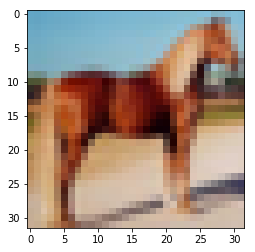

In [9]:
lab2txt = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

idx = 43
plt.imshow(train_x[idx])
print(lab2txt[np.argmax(train_y[idx])])

# Model

### Manually Specify Model

Helpers

In [30]:
def my_conv2d(tensor, nb_out, filter_size, stride):
    """
    Params:
        tensor - input tensor to conv layer
        filter_size - [filt_w, filt_h]
        nb_out - scalar
        stride - [stride_x, stride_y]
    """
        
    tensor_depth = int(tensor.shape[-1])
    N_in = np.prod(filter_size) * tensor_depth
    weights = tf.Variable(
        initial_value=tf.truncated_normal(
            mean=0.0,
            # stddev=N_in**-.5,
            stddev=(2/(N_in+nb_out))**.5,
            shape=[*filter_size, tensor_depth, nb_out],
            dtype=tf.float32))
    
    biases = tf.Variable(
        initial_value=tf.zeros(
            shape=nb_out,
            dtype=tf.float32))
    
    temp = tf.nn.conv2d(tensor, weights, [1, *stride, 1], padding='SAME')
    temp = tf.nn.bias_add(temp, biases)
    temp = tf.nn.relu(temp)
    
    return temp
    # return tf.nn.max_pool(temp, [1, *pool_ksize, 1], [1, *pool_strides, 1], padding='SAME')

In [31]:
def my_flatten(tensor):
    # auto
    return tf.layers.flatten(tensor)

    # manual
    target_shape = [-1, np.prod(tensor.get_shape()[1:])]
    return tf.reshape(x_tensor, target_shape)

In [32]:
def my_dense(tensor, nb_out, act):
    # auto
    # weights variable - gorlot init
    # biases variable - default yes, zeros init
    return tf.layers.dense(tensor, nb_out, activation=act)


Actual Model

In [33]:
tf.reset_default_graph()

xi = tf.placeholder(name='xi', shape=[None, 32, 32, 3], dtype=tf.float32)
yi = tf.placeholder(name='yi', shape=[None, 10], dtype=tf.float32)
kp = tf.placeholder(name='kp', shape=[], dtype=tf.float32)

# model = tf.layers.conv2d(
#     inputs=xi,
#     filters=32,
#     kernel_size=[5, 5],
#     strides=[1, 1],
#     padding='SAME',
#     activation=tf.nn.relu,
#     # use_bias=True,
# )
model = my_conv2d(xi, nb_out=32,
                      filter_size=[5, 5],                      
                      stride=[1, 1])

# model = tf.layers.max_pooling2d(
#     inputs=model,
#     pool_size=[2, 2],
#     strides=[2, 2],
#     padding='SAME')
model = tf.nn.max_pool(model, [1, *[2, 2], 1], [1, *[2, 2], 1], padding='SAME')



model = my_conv2d(model,
                  nb_out=64,
                  filter_size=[5, 5],
                  stride=[1, 1])
model = tf.nn.max_pool(model,
                       ksize=[1, *[2, 2], 1],
                       strides=[1, *[2, 2], 1],
                       padding='SAME')

model = my_conv2d(model,
                  nb_out=128,
                  filter_size=[5, 5],
                  stride=[1, 1])
model = tf.nn.max_pool(model,
                       ksize=[1, *[2, 2], 1],
                       strides=[1, *[2, 2], 1],
                       padding='SAME')

model = my_flatten(model)

model = my_dense(model, 1024, act=tf.nn.relu)

model = tf.nn.dropout(model, kp)

logits = my_dense(model, 10, act=None)

# probabilities = tf.nn.softmax(logits)  # not used

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=yi))
optimizer = tf.train.AdamOptimizer().minimize(loss)

is_correct = tf.equal(tf.argmax(logits, 1), tf.argmax(yi, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))


### High-Level Model

In [35]:
tf.reset_default_graph()

xi = tf.placeholder(name='xi', shape=[None, 32, 32, 3], dtype=tf.float32)
yi = tf.placeholder(name='yi', shape=[None, 10], dtype=tf.float32)
kp = tf.placeholder(name='kp', shape=[], dtype=tf.float32)

model = tf.layers.conv2d(xi,
    filters=32, kernel_size=[5, 5], strides=[1, 1], padding='SAME', activation=tf.nn.relu)
model = tf.layers.max_pooling2d(model,
    pool_size=[2, 2], strides=[2, 2], padding='SAME')

model = tf.layers.conv2d(model,
    filters=64, kernel_size=[5, 5], strides=[1, 1], padding='SAME', activation=tf.nn.relu)
model = tf.layers.max_pooling2d(model,
    pool_size=[2, 2], strides=[2, 2], padding='SAME')

model = tf.layers.conv2d(model,
    filters=128, kernel_size=[5, 5], strides=[1, 1], padding='SAME', activation=tf.nn.relu)
model = tf.layers.max_pooling2d(model,
    pool_size=[2, 2], strides=[2, 2], padding='SAME')

model = tf.layers.flatten(model)
model = tf.layers.dense(model, 1024, activation=tf.nn.relu)
model = tf.nn.dropout(model, kp)
logits = tf.layers.dense(model, 10, activation=None)

# probabilities = tf.nn.softmax(logits)  # not used

loss = tf.losses.softmax_cross_entropy(yi, logits)
optimizer = tf.train.AdamOptimizer().minimize(loss)

is_correct = tf.equal(tf.argmax(logits, 1), tf.argmax(yi, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

### Train Loop

Hyperparameters

In [27]:
epochs = 5 # 40
batch_size = 256
keep_probability = 0.75

Train Loop

In [36]:
saver = tf.train.Saver()
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        for batch_i, idx in enumerate(range(0, len(train_x), batch_size)):
            
            xb = train_x[idx:idx+batch_size]
            yb = train_y[idx:idx+batch_size]
            
            sess.run([optimizer, loss], feed_dict={xi: xb, yi: yb, kp: keep_probability})
            
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        train_cost, train_acc = sess.run([loss, accuracy], feed_dict={xi: xb, yi: yb, kp: 1.0})
        valid_cost, valid_acc = sess.run([loss, accuracy], feed_dict={xi: valid_x, yi: valid_y, kp: 1.0})
        print('tc, vc, tacc, vacc', train_cost, valid_cost, train_acc, valid_acc)
        
    saver.save(sess, './model.ckpt')

Epoch  1, CIFAR-10 Batch 175:  tc, vc, tacc, vacc 1.4183801 1.3584392 0.495 0.513
Epoch  2, CIFAR-10 Batch 175:  tc, vc, tacc, vacc 1.1791834 1.11534 0.565 0.605
Epoch  3, CIFAR-10 Batch 175:  tc, vc, tacc, vacc 0.96218544 0.9799994 0.68 0.6566
Epoch  4, CIFAR-10 Batch 175:  tc, vc, tacc, vacc 0.8473726 0.9014359 0.69 0.6834
Epoch  5, CIFAR-10 Batch 175:  tc, vc, tacc, vacc 0.725403 0.8550748 0.74 0.7002


In [24]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './model.ckpt')
    
    train_cost, train_acc = sess.run([loss, accuracy], feed_dict={xi: train_x[:10000], yi: train_y[:10000], kp: 1.0})
    valid_cost, valid_acc = sess.run([loss, accuracy], feed_dict={xi: valid_x, yi: valid_y, kp: 1.0})
    test_cost, test_acc   = sess.run([loss, accuracy], feed_dict={xi: test_x,  yi: test_y,  kp: 1.0})
    print('Train Set Accuracy:', train_acc)
    print('Validation Set Acc:', valid_acc)
    print('Test Set Accuracy: ', test_acc)

INFO:tensorflow:Restoring parameters from ./model.ckpt
Train Set Accuracy: 0.7665
Validation Set Acc: 0.7058
Test Set Accuracy:  0.6914
